# Plots for the 2MDM analysis

In [7]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from auxPlots import columnsDict, colorDict, defaultPars
from scipy.interpolate import griddata
import itertools

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings
plt.rcParams.update(defaultPars) #Figure resolution

#### Get data in pcl format and print all columns names

In [12]:
#Merge with SModelS DataFrame
pclFile = '../data/smodels_results.pcl'
dataDF = pd.read_pickle(pclFile)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['maxcond', 'theory prediction (fb)', 'upper limit (fb)', 'expected upper limit (fb)', 'TxNames', 'Mass (GeV)', 'AnalysisID', 'DataSetID', 'AnalysisSqrts (TeV)', 'lumi (fb-1)', 'dataType', 'r', 'r_expected', 'Width (GeV)', 'nll', 'nll_min', 'nll_SM', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'BRs.sd.t-,t+', 'totalxsec13TeV

### Remove results with gq = 0.1 and gchi = 0.6

In [13]:
dataDF = dataDF[~((dataDF['gchi'] == 0.6) & (dataDF['gq'] == 0.1))]

### Select combined analysis

In [15]:
combinedDF = dataDF[dataDF['AnalysisID'] == 'ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004']
# Sort by r, so highest value comes first
combinedDF = combinedDF.sort_values(by='r',axis=0,ascending=False)
# Keep only the strongest result for the combined analysis (first entry)
# (this step is only necessary if there is more than one result for the combined analysis, which should not happen)
combinedDF = combinedDF.groupby(level='filename').head(1)
print(len(combinedDF))


8732


### Group Combined Results by couplings

In [16]:
combinedGroups = combinedDF.groupby(by=['gchi','gq'])

#### Create legends for plots

In [17]:
gqLegend = {}
couplingsTuples = [gTuple for gTuple,_ in sorted(combinedGroups, key = lambda x: sum(x[0]), reverse=True)]

colors = [colorDict['ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004'],'cadetblue','skyblue']
# colors += list(sns.color_palette("Blues",len(couplingsTuples)+2,reverse=True).as_hex())[:len(couplingsTuples)-1]
# colors += sns.dark_palette("#69d", 10,reverse=True).as_hex()[0:1]+ sns.dark_palette("#69d", 10,reverse=True).as_hex()[4:5]

linestyles = ['solid','dotted','dashed']
# gqcolorsMono = dict(zip(couplingsTuples,['#ece7f2','#a6bddb','#2b8cbe']))
gqcolorsMono = dict(zip(couplingsTuples,colors))
gqstylesMono = dict(zip(couplingsTuples,linestyles))
for (gchi,gq), color in gqcolorsMono.items():
    if abs(gchi-np.sqrt(2)) < 0.001:
        label = r'$g_{\chi} = \sqrt{2}, g_{q} = %1.2f$' %(gq)
    else:
        label = r'$g_{\chi} = %1.0f, g_{q} = %1.2f$' %(gchi,gq)
    # l = mpatches.Patch(color=color, label=label)
    gqLegend[(gchi,gq)] = label

### Plot only excluded points for a selected $g_{q}, g_{\chi}$ pair

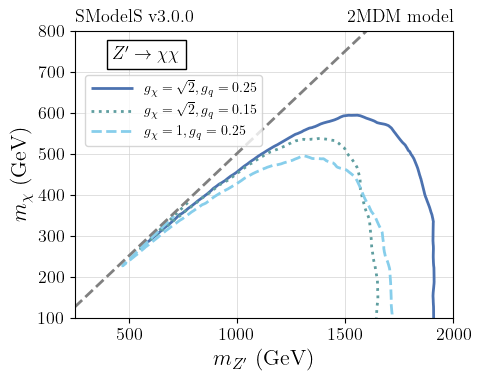

In [19]:
legends = {}
for gTuple, gDF in sorted(combinedGroups, key = lambda x: sum(x[0]), reverse=True):

    rData = gDF['r']
    x = gDF['mZp']
    y = gDF['mChi']
    pts = np.array(list(itertools.product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))))
    rPts = griddata(list(zip(x,y)),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], 
                        colors=gqcolorsMono[gTuple],linewidths=2.0,
                        linestyles=gqstylesMono[gTuple])

    legends[gqLegend[gTuple]] = cs.legend_elements()[0][0]

plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')

plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.ylim(100, 800) 
plt.xlim(250, 2000)

plt.text(0.1,0.9,r'$Z^\prime \to \chi \chi$',
            bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.legend(handles = legends.values(), labels=legends.keys(), loc='upper left',  handlelength=3,
           bbox_to_anchor=(0.01,0.87))

plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_monojet_curves.png')
plt.show()